# Exp 38

### Compare models on 28 classes

31 classes that have 200 or more files, minus 'text' and 'unk' that are not filetypes.

In [18]:
import os
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda
import tensorflow.keras.backend as K

In [4]:
raw_dataset_folder='/home/user/sample200'
# raw_dataset_folder='../datasets/govdocs1/sample200'
random_dataset_folder='../datasets/random'
minimum=200
maximum=200
result_dir = 'results/exp38'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [5]:
model = models.C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D(
        28, 8, 'softmax', 'categorical_crossentropy')

In [6]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

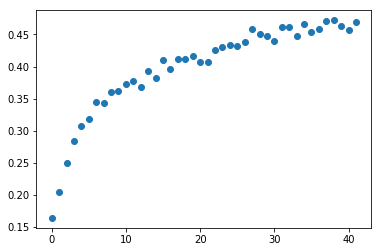

In [7]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [21]:
result.model.save(result_dir + '/28classes.h5')

In [ ]:
r = report.Reporter2(result_dir + '/28classes.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

In [44]:
pd.read_csv(result_dir + '/28classes.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C64_16_2pr_C32_4_2pr_C64_32_2pr_F_D28_cat,256.885371,42,0.972862,0.468625


# CLD

In [37]:
model = models.C256_16_16_L128_D(28, 8, 'softmax', 'categorical_crossentropy')

In [38]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


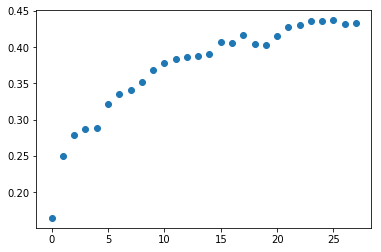

In [39]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [40]:
result.model.save(result_dir + '/28classes-CLD.h5')

In [41]:
r = report.Reporter2(result_dir + '/28classes-CLD.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

In [42]:
pd.read_csv(result_dir + '/28classes-CLD.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,C256_16_16_L128_D28_cat,205.507304,28,0.971437,0.433875


# Attention

In [29]:
def Attention(timesteps, nfeatures, name):
    def f(last):
        TIMESTEPS=timesteps
        NFEATURES=nfeatures
        query = last                                        # (None, TIMESTEPS, NFEATURES)
        # pick one of the convolutions
        query = MaxPooling1D(pool_size=TIMESTEPS,strides=1)(query)  # (None, 1, NFEATURES)
        # remove dimension with size 1
        query = Lambda(lambda q: K.squeeze(q, 1))(query)    # (None, NFEATURES)
        query = Dense(NFEATURES)(query)                     # (None, NFEATURES)
        attScores = Dot(axes=[1, 2])([query, last])         # (None, TIMESTEPS)
        attScores = Softmax(name=name)(attScores)
        # apply attention scores
        attVector = Dot(axes=[1, 1])([attScores, last])     # (None, NFEATURES)
        last = attVector
        return last
    return f

In [30]:
def mkmodel(classes, len_byte_vector, activation='softmax', loss='categorical_crossentropy'):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(64, (16,), strides=1, padding='same', activation='relu')(last)
    last = Conv1D(32, (4,), strides=1, padding='same', activation='relu')(last)
    last = Attention(512, 32, name='attScores')(last)
    last = Dense(classes)(last)
    last = Activation(activation)(last)
    model = tensorflow.keras.Model(l0, last, name='attentionModel')
    model.compile(loss=loss,
        optimizer=tensorflow.keras.optimizers.Adam(),
        metrics=['categorical_accuracy', 'binary_accuracy'])
    return model

In [31]:
model = mkmodel(28, 8)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 512, 8)       0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 512, 64)      8256        input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 512, 32)      8224        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 1, 32)        0           conv1d_15[0][0]                  
__________________________________________________________________________________________________
lambda_5 (

In [33]:
result = Trainer(model).train(*rawset.rnd_split_fraction_by_category(0.5))

Instructions for updating:
Use tf.cast instead.
20/20 [==============================] - 7s 330ms/step - loss: 1.8627 - categorical_accuracy: 0.3968 - binary_accuracy: 0.9703


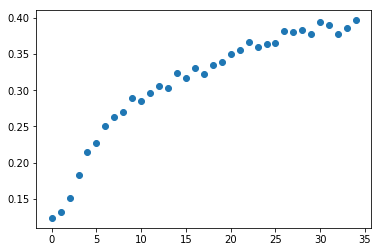

In [34]:
plt.plot(result.history.history['val_categorical_accuracy'], 'o')

In [35]:
result.model.save(result_dir + '/28classes-attention.h5')

In [36]:
r = report.Reporter2(result_dir + '/28classes-attention.tsv')

r.line(name=result.model.name,
       elapsed=result.elapsed,
       **report.report_epochs(**result._asdict()),
       **report.report_metrics(result.history, result.metrics),
      )

r.close()

In [37]:
pd.read_csv(result_dir + '/28classes-attention.tsv', sep='\t')

,name,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,attentionModel,615.242611,35,0.970264,0.39675


# Show attention

In [60]:
from IPython.core.display import HTML

In [124]:
def showHex(sample, model, attention_layer_model, n):
    attention_output = attention_layer_model.predict(sample)
    prediction = model.predict(sample)
    print(np.argmax(prediction[n]))
    print(rawset.ix_to_cat[np.argmax(prediction[n])])
    data2=np.argmax(sample[0][n],axis=1)
    x = normColor(attention_output[n])
    hex, printable = hexdump(data2)
    s = ""
    s+='<div style="font-family:monospace;font-size:10px;">'
    for i in range(0,512,16):
        s+="<div>"
        for j in range(16):
            s+='<span style="background-color: rgba(255,%d,%d,1);">%s </span>'%(x[i+j],x[i+j],hex[i+j])
        s+=" | "
        for j in range(16):
            s+='<span style="background-color: rgba(255,%d,%d,1);">%s</span>'%(x[i+j],x[i+j],printable[i+j])
        s+="</div>"
    s+=('</div>')
    return HTML(s)

In [125]:
def hexdump(chars):
    FILTER = ''.join([(len(repr(chr(x))) == 3) and chr(x) or '.' for x in range(256)])
    hex = ["%02x" % x for x in chars]
    printable = ["%s" % ((x <= 127 and FILTER[x]) or '.') for x in chars]
    return hex, printable

In [126]:
def normColor(attention_output):
    xmax=np.max(attention_output)
    xmin=np.min(attention_output)
    x = np.array(attention_output).reshape((512))
    x=(x-xmin)/(xmax-xmin)
    x = 255-(250*x+5)
    return x

In [119]:
by_category = rawset.by_category()
batch_size = 100
mycat = by_category['pdf']
mycat.rebuild_categories(rawset.categories)
sampler = block_sampler.BlockSamplerByFile(by_category['pdf'])
encoder = batch_encoder.BatchEncoder(sampler, batch_size=batch_size,xs_encoder='8bits_11')
itencoder = iter(encoder)

In [102]:
sample = next(itencoder)

In [103]:
model = tensorflow.keras.models.load_model(result_dir + '/28classes-attention.h5')

In [104]:
layer_name = 'attScores'
attention_layer_model = tensorflow.keras.Model(inputs=model.input,
                                               outputs=model.get_layer(layer_name).output)
attention_output = attention_layer_model.predict(sample)

In [105]:
attention_output.shape

(100, 512)

In [108]:
np.argmax(sample[1],axis=1)

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [128]:
prediction = model.predict(sample)
prediction.shape

(100, 28)

<BarContainer object of 28 artists>

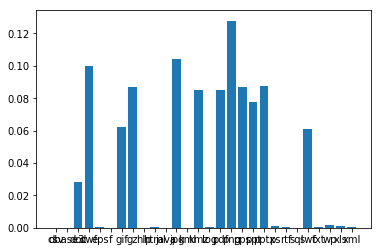

In [137]:
plt.bar([rawset.ix_to_cat[x] for x in range(28)], prediction[0])

In [120]:
showHex(sample,model,attention_layer_model, 6)

[[1.47035935e-05 1.30826549e-04 2.83225402e-02 ... 1.57158368e-03
  1.13321259e-03 7.09535263e-04]
 [1.93217405e-04 1.61760824e-03 1.61948204e-01 ... 3.13802481e-01
  1.15566172e-01 3.01789795e-03]
 [2.20473967e-02 8.10377125e-04 1.56980834e-03 ... 4.19650227e-03
  2.06974754e-03 3.92324701e-02]
 ...
 [2.10601487e-04 2.78667634e-04 1.88148748e-02 ... 5.65418461e-03
  1.43900374e-03 2.11701123e-03]
 [2.22302356e-06 2.55586401e-05 1.59884561e-02 ... 6.33714313e-04
  2.42187511e-04 2.71419442e-04]
 [1.39434051e-05 4.83905060e-05 1.10978382e-02 ... 1.53370295e-03
  5.90832962e-04 3.69621353e-04]]
swf
